In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gauravduttakiit/ants-bees
!unzip ants-bees.zip -d data

Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/ants-bees
License(s): DbCL-1.0
 95% 43.0M/45.1M [00:02<00:00, 21.4MB/s]
100% 45.1M/45.1M [00:02<00:00, 16.7MB/s]
Archive:  ants-bees.zip
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: data/hymenoptera_data/train/ants/1286

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

In [3]:
from torchvision.io import read_image

ant_image = read_image("/content/data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg")
bee_image = read_image("/content/data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg")

print(ant_image.shape)
print(bee_image.shape)

torch.Size([3, 333, 500])
torch.Size([3, 333, 500])


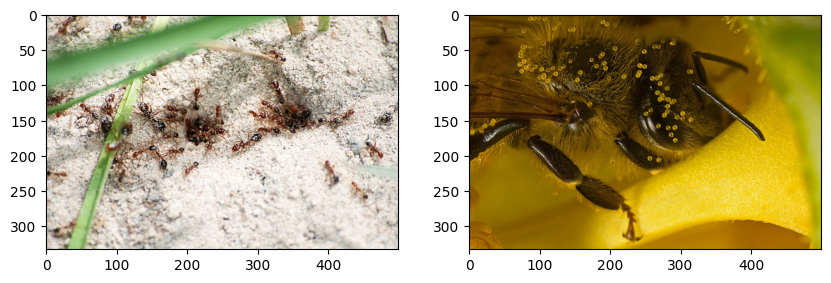

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(ant_image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(bee_image.permute(1,2,0))

Creating our dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image

class AntBeeDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        def is_image_file(filename):
          return filename.endswith(('.png', '.jpg', '.jpeg'))

        self.ant_images = [os.path.join(root, "ants", img) for img in os.listdir(os.path.join(root, "ants")) if is_image_file(img)]
        self.bee_images = [os.path.join(root, "bees", img) for img in os.listdir(os.path.join(root, "bees")) if is_image_file(img)]

        self.images = self.ant_images + self.bee_images
        self.labels = [0] * len(self.ant_images) + [1] * len(self.bee_images)

    def __getitem__(self, i):
        try:
            image_pth = self.images[i]
            image = read_image(image_pth)
            label = self.labels[i]

            if self.transforms:
                image = self.transforms(image)

        except Exception as e:
            print(f"Error loading image at index {i}: {image_pth}")
            print(e)
            raise e

        return image, label

    def __len__(self):
        return len(self.images)


In [18]:
root = "/content/data/hymenoptera_data/train"
ant_images = [os.path.join(root, "ants", img) for img in os.listdir(os.path.join(root, "ants"))]
bee_images = [os.path.join(root, "bees", img) for img in os.listdir(os.path.join(root, "bees"))]

images = ant_images + bee_images
labels = [0] * len(ant_images) + [1] * len(bee_images)
image_pth = images[58]
try:
    image = read_image(image_pth)
    print("Image loaded successfully")
except Exception as e:
    print(f"Error loading image at index 59: {image_pth}")
    print(e)

Error loading image at index 59: /content/data/hymenoptera_data/train/ants/.ipynb_checkpoints
unable to mmap 4096 bytes from file </content/data/hymenoptera_data/train/ants/.ipynb_checkpoints>: No such device (19)


Fine-tuning ConvNet

In [6]:
model = torchvision.models.resnet18(weights="DEFAULT")
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [5]:
from torchvision.transforms import v2 as T

def get_transform(train):
  transforms = []

  if train:
    transforms.append(T.RandomResizedCrop(224))
    transforms.append(T.RandomHorizontalFlip())
    transforms.append(T.ToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

  else:
    transforms.append(T.Resize(256))
    transforms.append(T.CenterCrop(224))
    transforms.append(T.ToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

  return T.Compose(transforms)

Running the model

In [20]:
num_epochs = 20
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_dataset = AntBeeDataset("/content/data/hymenoptera_data/train", get_transform(True))
validation_dataset = AntBeeDataset("/content/data/hymenoptera_data/val", get_transform(False))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if batch_idx % 10 == 9:
      print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {running_loss/10:.4f}")

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in validation_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_loss /= len(validation_loader)
  accuracy = 100 * correct / total

  print(f"Epoch: {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch: 1/20, Batch: 10/61, Loss: 0.4369
Epoch: 1/20, Batch: 20/61, Loss: 0.7405
Epoch: 1/20, Batch: 30/61, Loss: 1.3661
Epoch: 1/20, Batch: 40/61, Loss: 1.7058
Epoch: 1/20, Batch: 50/61, Loss: 2.1388
Epoch: 1/20, Batch: 60/61, Loss: 2.4667
Epoch: 1/20, Validation Loss: 0.4061, Validation Accuracy: 81.70%
Epoch: 2/20, Batch: 10/61, Loss: 0.2725
Epoch: 2/20, Batch: 20/61, Loss: 0.6921
Epoch: 2/20, Batch: 30/61, Loss: 1.1951
Epoch: 2/20, Batch: 40/61, Loss: 1.7048
Epoch: 2/20, Batch: 50/61, Loss: 2.1084
Epoch: 2/20, Batch: 60/61, Loss: 2.4056
Epoch: 2/20, Validation Loss: 0.3848, Validation Accuracy: 85.62%
Epoch: 3/20, Batch: 10/61, Loss: 0.3345
Epoch: 3/20, Batch: 20/61, Loss: 0.6965
Epoch: 3/20, Batch: 30/61, Loss: 1.0081
Epoch: 3/20, Batch: 40/61, Loss: 1.2535
Epoch: 3/20, Batch: 50/61, Loss: 1.7674
Epoch: 3/20, Batch: 60/61, Loss: 2.1208
Epoch: 3/20, Validation Loss: 0.6654, Validation Accuracy: 75.82%
Epoch: 4/20, Batch: 10/61, Loss: 0.2739
Epoch: 4/20, Batch: 20/61, Loss: 0.5910
Ep

Visualizing the predictions

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [10]:
import matplotlib.pyplot as plt
import torch

def visualize_model_2(model, validation_loader, class_names, device, num_images=6):
    was_training = model.training
    model.eval()

    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    # Tracking how many ants and bees have been displayed
    displayed = {class_name: 0 for class_name in class_names}
    target_per_class = num_images // len(class_names)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                predicted_class = class_names[preds[j]]

                if displayed[predicted_class] < target_per_class:
                    images_so_far += 1
                    displayed[predicted_class] += 1

                    row = (displayed[predicted_class] - 1)
                    col = class_names.index(predicted_class)

                    ax = plt.subplot(target_per_class, len(class_names), row * len(class_names) + col + 1)
                    ax.axis('off')
                    ax.set_title(f'{predicted_class}')

                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        plt.tight_layout()
                        plt.show()
                        return
        model.train(mode=was_training)
        plt.tight_layout()
        plt.show()

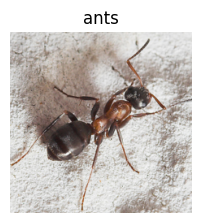

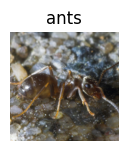

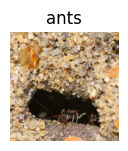

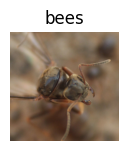

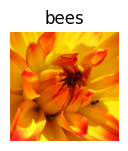

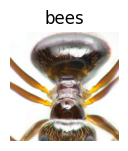

<Figure size 640x480 with 0 Axes>

In [26]:
visualize_model_2(model, validation_loader=validation_loader, class_names=['ants', 'bees'], device=device)

ConvNet as a fixed feature extractor

In [6]:
model_2 = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for params in model_2.parameters():
  params.requires_grad = False

num_features = model_2.fc.in_features
model_2.fc = nn.Linear(num_features, 2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_2 = model_2.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


Training

In [9]:
num_epochs = 20
lr = 0.0001
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_dataset = AntBeeDataset("/content/data/hymenoptera_data/train", get_transform(True))
validation_dataset = AntBeeDataset("/content/data/hymenoptera_data/val", get_transform(False))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

for epoch in range(num_epochs):
  model_2.train()
  running_loss = 0.0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_2(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if batch_idx % 10 == 9:
      print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {running_loss/10:.4f}")

  model_2.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in validation_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model_2(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_loss /= len(validation_loader)
  accuracy = 100 * correct / total

  print(f"Epoch: {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

Epoch: 1/20, Batch: 10/61, Loss: 0.6835
Epoch: 1/20, Batch: 20/61, Loss: 1.3722
Epoch: 1/20, Batch: 30/61, Loss: 2.0888
Epoch: 1/20, Batch: 40/61, Loss: 2.7092
Epoch: 1/20, Batch: 50/61, Loss: 3.4040
Epoch: 1/20, Batch: 60/61, Loss: 4.0417
Epoch: 1/20, Validation Loss: 0.5819, Validation Accuracy: 69.93%
Epoch: 2/20, Batch: 10/61, Loss: 0.6825
Epoch: 2/20, Batch: 20/61, Loss: 1.3767
Epoch: 2/20, Batch: 30/61, Loss: 2.0574
Epoch: 2/20, Batch: 40/61, Loss: 2.6828
Epoch: 2/20, Batch: 50/61, Loss: 3.2717
Epoch: 2/20, Batch: 60/61, Loss: 3.8813
Epoch: 2/20, Validation Loss: 0.4931, Validation Accuracy: 79.74%
Epoch: 3/20, Batch: 10/61, Loss: 0.5874
Epoch: 3/20, Batch: 20/61, Loss: 1.2963
Epoch: 3/20, Batch: 30/61, Loss: 1.9008
Epoch: 3/20, Batch: 40/61, Loss: 2.5456
Epoch: 3/20, Batch: 50/61, Loss: 3.1569
Epoch: 3/20, Batch: 60/61, Loss: 3.7494
Epoch: 3/20, Validation Loss: 0.4638, Validation Accuracy: 81.05%
Epoch: 4/20, Batch: 10/61, Loss: 0.5550
Epoch: 4/20, Batch: 20/61, Loss: 1.0338
Ep

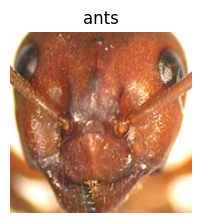

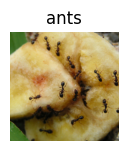

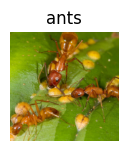

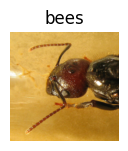

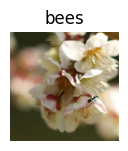

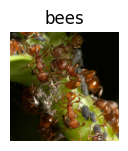

<Figure size 640x480 with 0 Axes>

In [13]:
visualize_model_2(model_2, validation_loader=validation_loader, class_names=['ants', 'bees'], device=device)

In [14]:
def custom_image_test(model, class_names, img_path):
  model.eval()
  image = read_image(img_path)
  image = get_transform(False)(image)
  print(image.shape)
  image = image.unsqueeze(0)
  print(image.shape)
  image = image.to(device)
  with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output.data, 1)

    for j in range(image.size()[0]):
      predicted_class = class_names[predicted[j]]
      print(f"Predicted class: {predicted_class}")
      ax = plt.subplot(1, 1, 1)
      ax.axis('off')
      ax.set_title(f'{predicted_class}')
      imshow(image.cpu().data[j])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Predicted class: bees


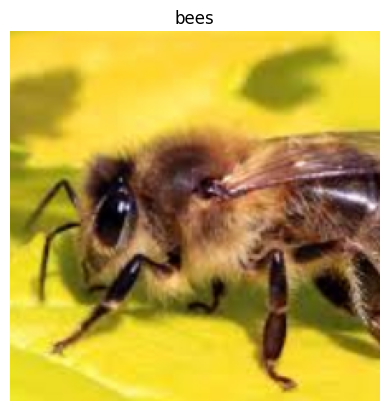

In [16]:
custom_image_test(model_2, class_names=["ants", "bees"], img_path= "/content/sample_data/bee.jpg")

In [20]:
%cd Deep-Learning-with-PyTorch/CV

/content/Deep-Learning-with-PyTorch/CV


In [25]:
!cp "/content/drive/MyDrive/Colab Notebooks/Transfer Learning with ConvNet (bees & ants).ipynb" "/content/Deep-Learning-with-PyTorch/CV"

In [23]:
!git add .

In [24]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
